# Filtering

We now move on to filtering out BCR contigs (and corresponding cells if necessary) from the BCR data and transcriptome object loaded in *scanpy*.

In [1]:
import os
import dandelion as ddl
import pandas as pd
import scanpy as sc

# change directory to holding tutorial data
os.chdir("dandelion_tutorial")

### Prepare the gene expression data

In [2]:
samples = [
    "sc5p_v2_hs_PBMC_1k_b",
    "sc5p_v2_hs_PBMC_10k_b",
    "vdj_v1_hs_pbmc3_b",
    "vdj_nextgem_hs_pbmc3_b",
]
adata_list = []
for sample in samples:
    adata = sc.read_10x_h5(
        sample + "/filtered_feature_bc_matrix.h5", gex_only=True
    )
    adata.obs["sample_id"] = sample
    # rename cells to sample id + barcode
    adata.obs_names = [str(sample) + "_" + str(j) for j in adata.obs_names]
    adata.var_names_make_unique()
    adata_list.append(adata)
adata = sc.concat(adata_list)
# rename the obs_names again, this time cleaving the trailing -#
adata.obs_names = [str(j).split("-")[0] for j in adata.obs_names]
adata

/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make

AnnData object with n_obs × n_vars = 30471 × 31915
    obs: 'sample_id'

I'm using a wrapper called `pp.recipe_scanpy_qc` to run through a generic [scanpy](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) workflow. You can skip this if you already have a pre-processed `AnnData` object for the subsequent steps.

In [3]:
ddl.pp.recipe_scanpy_qc(adata, mito_cutoff=None)  # use a gmm model to decide
# we can continue with those that survive qc
adata = adata[adata.obs["filter_rna"] == "False"].copy()
adata

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/Caskroom/miniforge/base/envs/dandelion/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
/Users/uqztuong/Documents/GitHub/dandelion/src/dandelion/external/scanpy/__init__.py:142: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


AnnData object with n_obs × n_vars = 23702 × 31915
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna'

## Filter cells that are potental doublets and poor quality in both the V(D)J data and transcriptome data

### `ddl.pp.check_contigs`

<div class="alert alert-warning">

Deprecation warning

Pre v0.5.0, there are two separate functions to perform contig QC with either `ddl.pp.filter_contigs` or `ddl.pp.check_contigs` to deal with poor quality contigs, either explicitly removing them or just flagging them.

`ddl.pp.filter_contigs` was removed from v1.0.0. `ddl.pp.check_contigs` is easier to maintain and simply marks the problematic contigs as `ambiguous` and withhold them from downstream analysis. `ddl.pp.check_contigs` also has `filter_extra` and `filter_ambiguous` options to remove/keep the `extra` (marked due to passing the internal QC filters but not explicitly ambiguous) and `ambiguous` contigs, fulfilling the same utility as `ddl.pp.filter_contigs`.
</div>

We use `ddl.pp.check_contigs` to mark and filter out cells and contigs from both the V(D)J data and transcriptome data in `AnnData`. The operation will remove bad quality cells based on transcriptome information as well as remove V(D)J doublets (multiplet heavy/long chains, and/or light/short chains) from the V(D)J data. In some situations, a single cell can have multiple heavy/long and light/short chain contigs although they have an identical V(D)J+C alignment; in situations like this, the contigs with lesser UMIs will be dropped and the UMIs transferred to `umi_count` column. The same procedure is applied to both chains before further checks of the annotation quality, UMI and consensus count distributions.

Cells in the gene expression object without V(D)J information will not be affected which means that the `AnnData` object can hold non-B/T cells.

In [4]:
# first we read in the 4 bcr files
bcr_files = []
for sample in samples:
    file_location = sample + "/dandelion/filtered_contig_dandelion.tsv"
    bcr_files.append(pd.read_csv(file_location, sep="\t"))
bcr = pd.concat(bcr_files, ignore_index=True)
bcr.reset_index(inplace=True, drop=True)
bcr

,sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,...,v_sequence_alignment_aa,d_sequence_alignment_aa,j_sequence_alignment_aa,complete_vdj,j_call_multimappers,j_call_multiplicity,j_call_sequence_start_multimappers,j_call_sequence_end_multimappers,j_call_support_multimappers,mu_count
0,sc5p_v2_hs_PBMC_1k_b_AACTCCCAGGCTAGGT_contig_1,ACTGCGGGGGTAAGAGGTTGTGTCCACCATGGCCTGGACTCCTCTC...,F,T,IGLV5-45*03,NaN,IGLJ3*02,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTG...,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTG...,TGTATGATTTGGCACAGCAGCGCTTGGGTGTTC,...,QAVLTQPSSLSASPGASASLTCTLRSGINVGTYRIYWYQQKPGSPP...,NaN,VFGGGTKLTVL,NaN,"[""IGLJ3*01""]",1,[397],[431],[5.29e-13],0
1,sc5p_v2_hs_PBMC_1k_b_AACTCCCAGGCTAGGT_contig_2,ATACTTTCTGAGAGTCCTGGACCTCCTGTGCAAGAACATGAAACAT...,F,T,IGHV4-61*02,IGHD3-3*01,IGHJ6*02,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTT...,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTT...,TGTGCGAGAGAAAATTACGATTTTTGGAGTGGTTATTACCACGGTG...,...,QVQLQESGPGLVKPSQTLSLTCTVSGGSISSGSYYWSWIRQPAGKG...,YDFWSGY,YHGADVWGQGTTVTVSS,NaN,"[""IGHJ6*02""]",1,[416],[470],[3.41e-19],3
2,sc5p_v2_hs_PBMC_1k_b_AACTCCCAGGCTAGGT_contig_3,GGCTGGGGTCTCAGGAGGCAGCGCTCTGGGGACGTCTCCACCATGG...,F,F,IGLV2-5*01,NaN,IGLJ3*02,CAGTCTGCCCTGATTCAGCCTCCCTCC...GTGTCCGGGTCTCCTG...,CAGTCTGCCCTGATTCAGCCTCCCTCC...GTGTCCGGGTCTCCTG...,TGCTGCTCATATACAAGCAGTGCCACTTTCTTGGGTGTTC,...,QSALIQPPSVSGSPGQSVTISCTGTSSDVGSYDYVSWYQQHPGTVP...,NaN,LGVRRRDQADRP,NaN,"[""IGLJ3*02""]",1,[396],[433],[2.45e-16],0
3,sc5p_v2_hs_PBMC_1k_b_AACTCTTGTCATCGGC_contig_2,AGCTCTGAGAGAGGAGCCTTAGCCCTGGATTCCAAGGCCTATCCAC...,F,T,IGHV3-21*01,IGHD3-22*01,IGHJ4*02,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,GAGGTGCAGCTGGTGGAGTCTGGGGGA...GGCCTGGTCAAGCCTG...,TGTGCGAGACGTTACTATGATAGTAGTGGTTATTCCGCAAACTTTG...,...,EVQLVESGGGLVKPGGSLRLSCAASGFTFSSYSMNWVRQAPGKGLE...,YYDSSGY,FDYWGQGTLVTVSS,NaN,"[""IGHJ4*02""]",1,[462],[506],[2.81e-20],0
4,sc5p_v2_hs_PBMC_1k_b_AACTCTTGTCATCGGC_contig_1,AGAGCTCTGGGGAGTCTGCACCATGGCTTGGACCCCACTCCTCTTC...,F,T,IGLV4-69*01,NaN,IGLJ1*01,CAGCTTGTGCTGACTCAATCGCCCTCT...GCCTCTGCCTCCCTGG...,CAGCTTGTGCTGACTCAATCGCCCTCT...GCCTCTGCCTCCCTGG...,TGTCAGACCTGGGGCACTGGCATTTATGTCTTC,...,QLVLTQSPSASASLGASVKLTCTLSSGHSSYAIAWHQQQPEKGPRY...,NaN,YVFGTGTKVTVL,NaN,"[""IGLJ1*01""]",1,[379],[416],[2.39e-16],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7350,vdj_nextgem_hs_pbmc3_b_TTTGCGCTCTGTCAAG_contig_2,ATCACATAACAACCACATTCCTCCTCTAAAGAAGCCCCCGGGAGCC...,F,T,"IGHV1-69*01,IGHV1-69D*01",IGHD3-22*01,IGHJ4*02,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAAGTGAAGAAGCCTG...,CAGGTGCAGCTGGTGCAGTCTGGGGCT...GAGGTGAAGAAGCCTG...,TGTGCGAGGGGGAAGTATTACTATGATAAAAGTGGGTCTCCACCTC...,...,QVQLVQSGAEVKKPGSSVKVSCKVSGGIFSSYAISWVRQAPGQGLE...,YYYDKSG,FDYWGQGTLVTVSS,NaN,"[""IGHJ4*02""]",1,[457],[500],[1.18e-19],16
7351,vdj_nextgem_hs_pbmc3_b_TTTGGTTGTAAGGATT_contig_1,AGAGCTCTGGAGAAGAGCTGCTCAGTTAGGACCCAGAGGGAACCAT...,F,T,IGKV3-20*01,NaN,"IGKJ2*01,IGKJ2*02",GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,GAAATTGTGTTGACGCAGTCTCCAGGCACCCTGTCTTTGTCTCCAG...,TGTCAGCAGTATGATGAGTCACCTCTGACTTTT,...,EIVLTQSPGTLSLSPGERATLSCRASQSLTNSQLAWYQQKPGQAPR...,NaN,TFGQGTKLEIK,NaN,"[""IGKJ2*02""]",1,[396],[429],[3.59e-14],11
7352,vdj_nextgem_hs_pbmc3_b_TTTGGTTGTAAGGATT_contig_2,AGCTCTGGGAGAGGAGCCCCAGCCCTGAGATTCCCAGGTGTTTCCA...,F,T,IGHV3-9*01,"IGHD5-18*01,IGHD5-5*01",IGHJ6*03,GAAGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,GAAGTGCAGCTGGTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,TGTGCAAAAGACGGATACAGCTATCGTTCGTCATACTACTTTTACA...,...,EVQLVESGGGLVQPGRSLRLSCAASGFSFDDYVMHWVRQAPGKGLE...,GYSYR,YYFYMDVWGKGTTVTVSS,NaN,"[""IGHJ6*03""]",1,[456],[510],[1.96e-22],10
7353,vdj_nextgem_hs_pbmc3_b_TTTGTCACAGTAGAGC_contig_1,AGCTCTGAGAGAGGAGCCCAGCCCTGGGATTTTCAGGTGTTTTCAT...,F,T,"IGHV3-23*01,IGHV3-23D*01",IGHD4-17*01,IGHJ4*02,GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,GAGGTGCAGCTGTTGGAGTCTGGGGGA...GGCTTGGTACAGCCTG...,TGTGCGAAAGATTTTAGGTCGCCATACGGTGACTACTACTTTGACT...,...,EVQLLESGGGLVQPGGSLRLSCAASG

<div class="alert alert-warning">

Library type
    
It is recommended to specify the <b><b>library_type</b></b> argument as it will remove all contigs that do not belong to the related loci. The rationale is that the choice of the library type should mean that the primers used would most likely amplify those related sequences and if there's any unexpected loci, they likely represent artifacts and shouldn't be analysed. The optional argument accepts: `ig`, `tr-ab`, `tr-gd` or `None` where `None` means all contigs will be kept.
</div>    

The main output of this function are two an additional columns in `vdj.data`, `extra` and `ambiguous`, which flags `T` or `F` for contigs that were marked accordingly. The rules for marking contigs are as follows:

`extra` is marked as `T` if the contig passes the internal QC filters based on `umi_count` (or `consensus_count` if there are ties in the `umi_count`) in a cell. If you are only interested in just the top contig pair, you can set `filter_extra=True` to remove the extra contigs.

For VDJ chains, the current rule set is to keep the **top 1** `productive` contig with the highest counts and mark the rest as `extra` (or `ambiguous` if appropriate). Toggle `ntop_vdj` to keep the top `n` (default 1) contigs.

For VJ chains, the current rule set is to keep the **top 2** `productive` contigs with the highest counts and mark the rest as `extra` (or `ambiguous` if appropriate). Toggle `ntop_vj` to keep the top `n` (default 2) contigs.

`ambiguous` is marked as `T` if the contig is of poor quality annotation and would be removed from downstream analysis. Cells with multiple contigs with very low `umi_counts` and/or `consensus_counts` are also marked as `ambiguous` as it is not possible to distinguish which is the most representative contig.

Please note that the default for `filter_extra` is `True`. If you want to keep the `extra` contigs for whatever reasons e.g. interested in T/B-cell development datasets, you need to set `filter_extra=False`. We are setting this as `False` in this example because later on we want to visualise these extra contigs.

In [5]:
vdj, adata = ddl.pp.check_contigs(
    bcr, adata, library_type="ig", filter_extra=False
)

Preparing data: 6503it [00:00, 7483.77it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 3158/3158 [00:07<00:00, 403.69it/s]
/Users/uqztuong/Documents/GitHub/dandelion/src/dandelion/utilities/_core.py:1065: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


### Check the `Dandelion` object

In [6]:
vdj

Dandelion class object with n_obs = 2236 and n_contigs = 7355
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

### Check the `AnnData` object as well

In [7]:
adata

AnnData object with n_obs × n_vars = 23702 × 31915
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'gmm_pct_count_clusters_keep', 'scrublet_score', 'is_doublet', 'filter_rna', 'has_contig', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'umi_count_B_VDJ', 'umi_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_B_VDJ_main', 'd_call_B_VDJ_main', 'j_call_B_VDJ_main', 'v_call_B_VJ_main', 'j_call_B_VJ_main', 'isotype', 'isotype_status', 'locus_status', 'chain_status', 'rearrangement_status_VDJ', 'rearrangement_status_

These are the relevant columns for looking at the QC status of the cells and contigs in the `.obs` slot in the `AnnData` object (and also `.metadata` slot in the `Dandelion` object):
<div class="alert alert-info">

Relevant columns in obs

- `has_contig`
- whether cells have V(D)J chains.<br><br>
    
- `locus_status`
- detailed information on chain status pairings (below).<br><br>
    
- `chain_status`
- summarised information of the chain locus status pairings (similar to `chain_pairing` in `scirpy`).<br><br>
    
- `rearrangement_status_VDJ` and  `rearrangement_status_VJ`
- whether or not V(D)J gene usage are standard (i.e. all from the same locus).

</div>

So in a standard situation, I would remove cells flagged with `Orphan VJ`, `Orphan VJ-exception`, `ambiguous` in `.metadata.chain_status`, and also any cell marked as `chimeric` in the `.metadata.rearrangement_status_VDJ` and `.metadata.rearrangement_status_VJ` from downstream cell-level calculations/analysis. 

Having said that, you will find that most of `Dandelion`'s functions will work without the need to requirement to perform additional filtering and filtering can be performed on the final `AnnData` object (described in the visualisation section).

<b>Let's take a look at these new columns</b>

In [8]:
pd.crosstab(adata.obs["chain_status"], adata.obs["locus_status"])

locus_status,Extra VDJ + Extra VJ,Extra VDJ + IGK,Extra VDJ + IGL,IGH + Extra VJ,IGH + IGK,IGH + IGL,No_contig,Orphan Extra VJ,Orphan IGH,Orphan IGK,Orphan IGL
chain_status,,,,,,,,,,,
Extra pair,58,4,4,84,0,0,0,0,0,0,0
No_contig,0,0,0,0,0,0,21466,0,0,0,0
Orphan Extra VJ,0,0,0,0,0,0,0,3,0,0,0
Orphan VDJ,0,0,0,0,0,0,0,0,9,0,0
Orphan VJ,0,0,0,0,0,0,0,0,0,83,39
Single pair,0,0,0,0,1126,826,0,0,0,0,0


if there are multiple library types, i.e. `ddl.pp.check_contigs` was run with `library_type = None`, or if several tcr/bcr `Dandelion` objects are concatenated, there will be additional columns where the `v/d/j/c calls` and `productive` will be split into additional columns to reflect those that belong to a B cell, alpha-beta T cell, or gamma-delta T cell.

## Now actually filter the AnnData object and run through a standard workflow starting by filtering genes and normalizing the data

Because the 'filtered' `AnnData` object was returned as a filtered but otherwise unprocessed object, we still need to normalize and run through the usual process here. The following is just a standard scanpy workflow.

In [9]:
# standard preprocessing steps
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable].copy()
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

### Visualizing the clusters and whether or not there's a corresponding V(D)J receptor

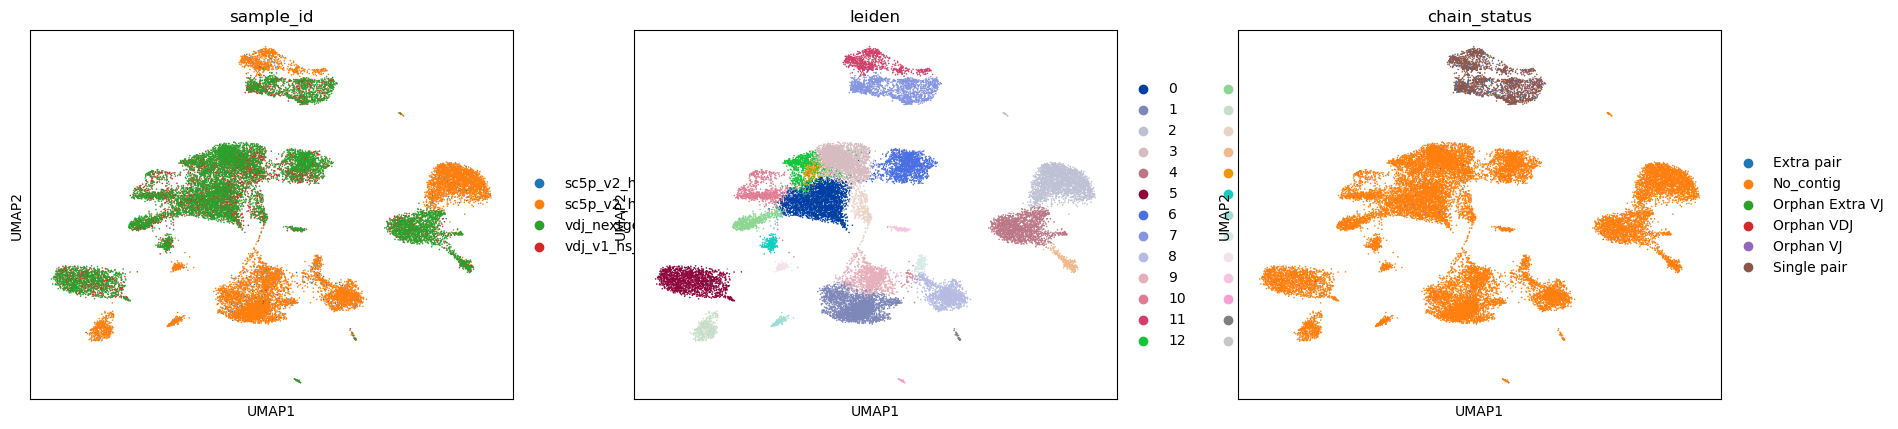

In [10]:
sc.pl.umap(adata, color=["sample_id", "leiden", "chain_status"])

### Visualizing some B cell genes

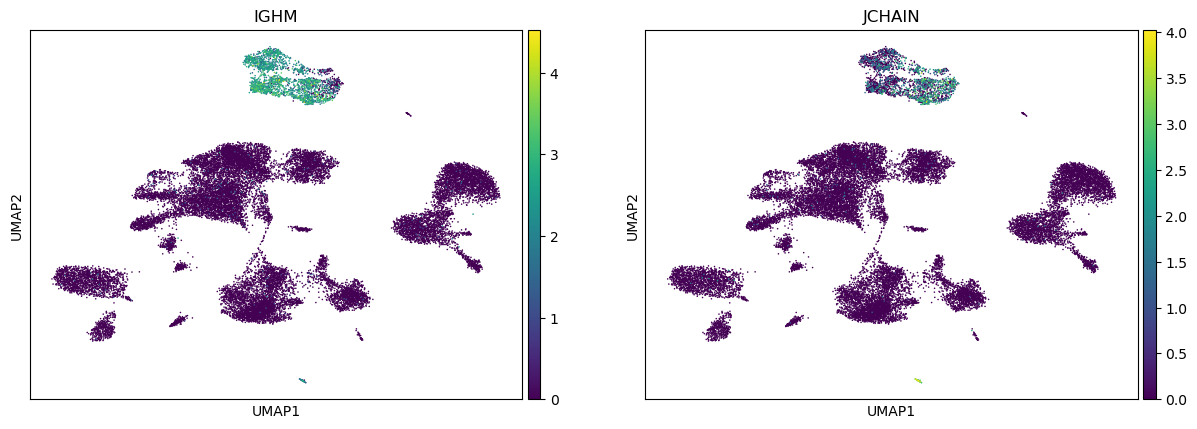

In [11]:
sc.pl.umap(adata, color=["IGHM", "JCHAIN"])

In [12]:
# We can save this AnnData object for now.
adata.write("adata.h5ad", compression="gzip")

### Save `dandelion` object

To save the vdj object, we have two options - either save the `.data` and `.metadata` slots with pandas' functions:

In [13]:
vdj.data.to_csv("filtered_vdj_table.tsv", sep="\t")

Or save the whole Dandelion class object with either `.write_h5ddl/.write`, which saves the class to a HDF5 format, or using a pickle-based `.write_pkl` function.

<div class="alert alert-warning">

From v0.4.0, the `.write_h5ddl/.write` function has been refactored to use `h5py`. Support for files saved prior to v0.4.0 (which used `pandas` to save in HDF5 format) will be maintained at least until the next major version and `ddl.read_h5ddl` will be able to read both old and new versions. The old version can be saved with `.write_h5ddl(..., version=3)` but this is not covered by tests because of issues with installing the dependencies.
</div>

In [14]:
vdj.write_h5ddl("dandelion_results.h5ddl")  # can add compression="gzip"

In [15]:
vdj.write_pkl(
    "dandelion_results.pkl.pbz2"
)  # this will automatically use bzip2 for compression, switch the extension to .gz for gzip

## Running `ddl.pp.check_contigs` without `AnnData`

Finally, `ddl.pp.check_contigs` can also be run without an `AnnData` object:

In [16]:
vdj3 = ddl.pp.check_contigs(bcr)
vdj3

Preparing data: 6503it [00:01, 5771.09it/s]
Scanning for poor quality/ambiguous contigs: 100%|██████████| 3158/3158 [00:07<00:00, 403.26it/s]
/Users/uqztuong/Documents/GitHub/dandelion/src/dandelion/utilities/_core.py:1065: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Dandelion class object with n_obs = 3157 and n_contigs = 6372
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 